# Code to analyze the locomotion test

In [1]:
#DEV
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import tables as tb
import h5py
import scipy.stats
import datetime
from scipy.ndimage.filters import gaussian_filter as smooth
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings

warnings.filterwarnings("ignore")
import sys
import pickle
import matplotlib.pyplot as plt

if OS() == 'Linux':
    root = "/data"
elif OS() == 'Windows':
    root = "C:\\DATA\\"
else:
    root = "/Users/davidrobbe/Documents/Data/"

param={
    "goalTime":7,#needed for pavel data only
    "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
    "maxTrialDuration":15,
    "interTrialDuration":10,#None pavel
    "endTrial_frontPos":30,
    "endTrial_backPos":55, 
    "endTrial_minTimeSec":4,
    "cameraSamplingRate":25, #needed for new setup    

    "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
    "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
    "nbJumpMax":100,#200 pavel
    "binSize":0.25,
    #parameters used to preprocess (will override the default parameters)
}  
ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
%run Animal_Tags.ipynb
%run UtilityTools.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb

os.chdir(CWD)

print('Done!')

Done!


In [ ]:
get_pattern_animalList(root,'*Reverse**')

#### ViewPoint intertrial analysis for Loco test

check normal exploration

In [4]:
def find_persistent_movement_epochs(pos: np.array, TrdSpeed: int, fs: int):
    """
    this function finds epochs in the position of a single trial, pos, where the animal has moved
    for a duration of at least, TH*cameraSamplingRate
    pos: position as a np.array
    """
    SpeedTolerance = 5 if TrdSpeed==0 else 10
    DurationTolerance= 0.4*fs
    
    pos_=smooth(pos,.3*fs,mode="nearest")
    velocity=np.append(TrdSpeed-(np.diff(pos_)*fs),TrdSpeed)
    
    zeroVel=np.logical_and(velocity<SpeedTolerance, velocity>-SpeedTolerance)
    
    movement= np.logical_not(zeroVel)
    movement=movement*1

    dpcross=np.absolute( np.append(movement,0) - np.append(0,movement) )
#     breakpoint()
    #any 1 in dpcross mean a zero-crossing in diff(pos)
    crossindex=np.where(dpcross)[0]
    crossindex=np.reshape(crossindex,(-1,2))
    movementepoch=crossindex[crossindex[:,1]-crossindex[:,0] > DurationTolerance]
    return movementepoch

def run_distance(data,trial=None):
    if trial is None:
        trial=list(data.position.keys())
    elif not hasattr(trial,'__iter__'):
        trial=[trial]
    
    dis=[0]
    for i in trial:
        et=(data.entranceTime[i]+data.cameraToTreadmillDelay)*data.cameraSamplingRate
        allTraj=data.position[i]
    #     allTraj=scipy.ndimage.filters.gaussian_filter1d(allTraj, sigma=data.cameraSamplingRate/5, truncate=3.0)
        if np.isnan(et):
            th=(data.maxTrialDuration[i]+data.cameraToTreadmillDelay)*data.cameraSamplingRate
            th=int(th)
        else:
            th=int(et)
        allTraj[th-1:]=np.nan
        treadmillStep=np.expand_dims(data.treadmillSpeed[i]/data.cameraSamplingRate,1)
        posMoveIndex=find_persistent_movement_epochs(allTraj,
                                                     TrdSpeed=data.treadmillSpeed[i],
                                                     fs=data.cameraSamplingRate)

        for i,j in posMoveIndex:
            epochPos=allTraj[int(i):int(j)]
            dis[-1]+=np.nansum(np.absolute(np.diff(epochPos)-treadmillStep))
        dis.append(0)

    return np.array(dis[:-1])

def intertrial_displacement(data,trial=None):
    if trial is None:
        trial=list(data.position.keys())
    elif not hasattr(trial,'__iter__'):
        trial=[trial]
    
    dis=[0]
    for i in trial:
        if data.dataType != 'ViewPoint':
            allTraj= data.position[i][int((-data.interTrialDuration[i]+1)*data.cameraSamplingRate):]
            TH=int(0.6*data.cameraSamplingRate)
        else:
            allTraj=data.rawIntertrialPosition[i]
            TH=int(0.6*data.cameraSamplingRateInterTrial)

        posMoveIndex=find_persistent_movement_epochs(allTraj,
                                                     TrdSpeed=0,
                                                     fs=data.cameraSamplingRateInterTrial
                                                     )

        for i,j in posMoveIndex:
            epochPos=allTraj[int(i):int(j)]
            dis[-1]+=np.nansum(np.absolute(np.diff(epochPos)))
        dis.append(0)

    return np.array(dis[:-1])

In [9]:
LesionAnimalList=['Rat325', 'Rat337', 'Rat341', 'Rat345']#, 'Rat329', 'Rat333']
NormalAnimalList=['Rat359','Rat360','Rat361','Rat356','Rat357','Rat358','Rat373','Rat349']

profile={'Type':'Good',
         'rewardType':'Progressive',
#          'initialSpeed':'10',
#          'Speed':['10'],
         'Tag':['Reverse-Late_DLS-EXP','Early-Lesion_DMS-EXP','Early-Lesion_DS-EXP',
                'Control-EXP','ImmobileTreadmill-EXP']
         }

AnimalList=NormalAnimalList
sessionList=batch_get_session_list(root,AnimalList,profile)['Sessions']

dis={}
disIT={}
for session in sessionList:
    animal=session[:6]
    data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
    dis[animal]  =(run_distance(data))
    disIT[animal]=intertrial_displacement(data)


In [10]:
EffectData=np.empty((len(AnimalList),2))
for i,session in enumerate(sessionList):
    animal=session[:6]
    EffectData[i,:]=( np.median(disIT[animal][:5])/2, np.median(disIT[animal][20:25]) )
#     EffectData: natural locomotion, locomotion after fast speed trial

In [11]:
#division due to length of intertirla being 60 instead of 30?!
print(np.round(EffectData))

[[ 93.  39.]
 [172.  58.]
 [109.  52.]
 [135.  20.]
 [  0.  66.]
 [104.  92.]
 [102.  68.]
 [120.  81.]]


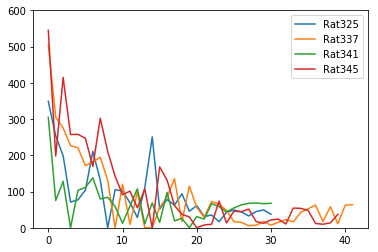

In [8]:
ax=plt.gca()

for animal,val in disIT.items():
    ax.plot(val,label=animal)
plt.ylim([0,600])
plt.legend()
plt.show()

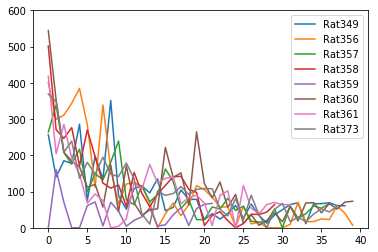

In [12]:
ax=plt.gca()

for animal,val in disIT.items():
    ax.plot(val,label=animal)
plt.ylim([0,600])
plt.legend()
plt.show()